In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import re

pd.set_option('display.max_columns', None)  # to display all rows and columns while printing.
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', -1)



Loading the data.

In [39]:
df = pd.read_csv(r"C:\Users\jvrdo\Downloads\Merged_QVI.csv", parse_dates= ['DATE'])
df.head()

,Unnamed: 0,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,product_size,product_name,price/chip,LIFESTAGE,PREMIUM_CUSTOMER,date_month,date_year,YEARMONTH
0,0,2018-10-17,1,1000,1,5,2,6.0,175,Natural Chip Compny SeaSalt,3.00,YOUNG SINGLES/COUPLES,Premium,10,2018,201810
1,1,2019-05-14,1,1307,348,66,3,6.3,175,CCs Nacho Cheese,2.10,MIDAGE SINGLES/COUPLES,Budget,5,2019,201905
2,2,2019-05-20,1,1343,383,61,2,2.9,170,Smiths Crinkle Cut Chips Chicken,1.45,MIDAGE SINGLES/COUPLES,Budget,5,2019,201905
3,3,2018-08-17,2,2373,974,69,5,15.0,175,Smiths Chip Thinly S/Cream&Onion,3.00,MIDAGE SINGLES/COUPLES,Budget,8,2018,201808
4,4,2018-08-18,2,2426,1038,108,3,13.8,150,Kettle Tortilla ChpsHny&Jlpno Chili,4.60,MIDAGE SINGLES/COUPLES,Budget,8,2018,201808


In [40]:
def monthly_store_metrics():
    store_yrmo_group = df.groupby(["STORE_NBR", "YEARMONTH"])
    total = store_yrmo_group["TOT_SALES"].sum()
    num_cust = store_yrmo_group["LYLTY_CARD_NBR"].nunique()
    trans_per_cust = store_yrmo_group.size() / num_cust
    avg_chips_per_cust = store_yrmo_group["PROD_QTY"].sum() / num_cust
    avg_chips_price = total / store_yrmo_group["PROD_QTY"].sum()
    aggregates = [total, num_cust, trans_per_cust, avg_chips_per_cust, avg_chips_price]
    metrics = pd.concat(aggregates, axis=1)
    metrics.columns = ["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"]
    return metrics

In [41]:
qvi_monthly_metrics = monthly_store_metrics().reset_index()
qvi_monthly_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231 entries, 0 to 1230
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STORE_NBR        1231 non-null   int64  
 1   YEARMONTH        1231 non-null   int64  
 2   TOT_SALES        1231 non-null   float64
 3   nCustomers       1231 non-null   int64  
 4   nTxnPerCust      1231 non-null   float64
 5   nChipsPerTxn     1231 non-null   float64
 6   avgPricePerUnit  1231 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 67.4 KB


Filtering only the stores with full 12 months observation.

In [43]:
#pre trial observation
#filter only stores with full 12 months observation
observ_counts = qvi_monthly_metrics["STORE_NBR"].value_counts()
full_observ_index = observ_counts[observ_counts == 12].index
full_observ = qvi_monthly_metrics[qvi_monthly_metrics["STORE_NBR"].isin(full_observ_index)]
pretrial_full = full_observ[full_observ["YEARMONTH"] < 201902]

pretrial_full.head()

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947


In [47]:
pretrial_full.isna().sum()

STORE_NBR          0
YEARMONTH          0
TOT_SALES          0
nCustomers         0
nTxnPerCust        0
nChipsPerTxn       0
avgPricePerUnit    0
dtype: int64

Function to find correlation between trial stores and control stores one by one.

In [59]:
def calcCorrTable(metricCol, storeComparison, inputTable=pretrial_full):
    """Calculate correlation for a measure, looping through each control store.
    Args:
        metricCol (str): Name of column containing store's metric to perform correlation test on.
        storeComparison (int): Trial store's number.
        inputTable (dataframe):  Metric table with potential comparison stores.
        
    Returns:
        DataFrame: Monthly correlation table between Trial and each Control stores.
    """
    control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    corrs = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
    trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol].reset_index()
    for control in control_store_nbrs:
        concat_df = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
        control_store = inputTable[inputTable["STORE_NBR"] == control][metricCol].reset_index()
        concat_df["Corr_Score"] = trial_store.corrwith(control_store, axis=1)
        concat_df["Trial_Str"] = storeComparison
        concat_df["Ctrl_Str"] = control
        concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
        corrs = pd.concat([corrs, concat_df])
    return corrs

In [68]:
def calculateMagnitudeDistance(metricCol, storeComparison, inputTable=pretrial_full_observ):
    """Calculate standardised magnitude distance for a measure, looping through each control store.
    Args:
        metricCol (str): Name of column containing store's metric to perform distance calculation on.
        storeComparison (int): Trial store's number.
        inputTable (dataframe):  Metric table with potential comparison stores.
        
    Returns:
        DataFrame: Monthly magnitude-distance table between Trial and each Control stores.
    """
    control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    dists = pd.DataFrame()
    trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol]
    for control in control_store_nbrs:
        concat_df  = abs(inputTable[inputTable["STORE_NBR"] == storeComparison].reset_index()[metricCol] - inputTable[inputTable["STORE_NBR"] == control].reset_index()[metricCol])
        concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
        concat_df["Trial_Str"] = storeComparison
        concat_df["Ctrl_Str"] = control
        dists = pd.concat([dists, concat_df])
    for col in metricCol:
        dists[col] = 1 - ((dists[col] - dists[col].min()) / (dists[col].max() - dists[col].min()))
    dists["magnitude"] = dists[metricCol].mean(axis=1)
    return dists  

In [69]:
dist_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    dist_table = pd.concat([dist_table, calculateMagnitudeDistance(["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"], trial_num)])
    
dist_table.head(8)
dist_table

,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,YEARMONTH,Trial_Str,Ctrl_Str,magnitude
0,0.952012,0.970000,0.933819,0.699915,0.898636,201807,77,1,0.890876
1,0.941676,0.950000,0.993486,0.799422,0.873764,201808,77,1,0.911669
2,0.946696,0.800000,0.998882,0.742437,0.673098,201809,77,1,0.832223
3,0.988188,0.930000,0.988941,0.941052,0.544899,201810,77,1,0.878616
4,0.989221,0.890000,0.908944,0.728662,0.826504,201811,77,1,0.868666
5,0.942931,0.960000,0.861553,0.856121,0.745260,201812,77,1,0.873173
6,0.963677,1.000000,0.779550,0.540528,0.642958,201901,77,1,0.785342
0,0.910594,0.930000,0.908248,0.639603,0.859782,201807,77,2,0.849646
1,0.954743,0.920000,0.790935,0.886947,0.953444,201808,77,2,0.901214
2,0.962052,0.970000,0.939549,0.649462,0.641057,201809,77,2,0.832424


In [70]:
def combine_corr_dist(metricCol, storeComparison, inputTable=pretrial_full_observ):
    corrs = calcCorrTable(metricCol, storeComparison, inputTable)
    dists = calculateMagnitudeDistance(metricCol, storeComparison, inputTable)
    dists = dists.drop(metricCol, axis=1)
    combine = pd.merge(corrs, dists, on=["YEARMONTH", "Trial_Str", "Ctrl_Str"])
    return combine

In [71]:
compare_metrics_table1 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table1 = pd.concat([compare_metrics_table1, combine_corr_dist(["TOT_SALES"], trial_num)])

In [72]:
corr_weight = 0.5
dist_weight = 1 - corr_weight

Comparing stores based on total sales:

In [73]:
#Top 5 highest Composite Score for each Trial Store based on TOT_SALES
grouped_comparison_table1 = compare_metrics_table1.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table1["CompScore"] = (corr_weight * grouped_comparison_table1["Corr_Score"]) + (dist_weight * grouped_comparison_table1["magnitude"])
for trial_num in compare_metrics_table1["Trial_Str"].unique():
    print(grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n')

    Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
49  77         53        1.0         0.981469   0.990735 
38  77         41        1.0         0.973295   0.986648 
42  77         46        1.0         0.972367   0.986184 
46  77         50        1.0         0.970996   0.985498 
81  77         90        1.0         0.963255   0.981627  

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
185  86         97        1.0         0.941005   0.970503 
189  86         101       1.0         0.938304   0.969152 
180  86         91        1.0         0.919757   0.959878 
192  86         104       1.0         0.909641   0.954821 
175  86         83        1.0         0.905739   0.952869  

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
233  88         40        1.0         0.941850   0.970925 
264  88         72        1.0         0.914997   0.957499 
199  88         4         1.0         0.908709   0.954355 
220  88         26        1.0         0.906121   0.953060 

Comparing stores based on monthly customers:

In [74]:
compare_metrics_table2 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table2 = pd.concat([compare_metrics_table2, combine_corr_dist(["nCustomers"], trial_num)])

In [75]:
#Top 5 highest Composite Score for each Trial Store based on nCustomers
grouped_comparison_table2 = compare_metrics_table2.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table2["CompScore"] = (corr_weight * grouped_comparison_table2["Corr_Score"]) + (dist_weight * grouped_comparison_table2["magnitude"])
for trial_num in compare_metrics_table2["Trial_Str"].unique():
    print(grouped_comparison_table2[grouped_comparison_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n')

    Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
49  77         53        1.0         0.961429   0.980714 
38  77         41        1.0         0.961429   0.980714 
42  77         46        1.0         0.958571   0.979286 
15  77         17        1.0         0.950000   0.975000 
70  77         74        1.0         0.948571   0.974286  

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
134  86         39        1.0         0.946092   0.973046 
156  86         62        1.0         0.944744   0.972372 
151  86         57        1.0         0.939353   0.969677 
189  86         101       1.0         0.936658   0.968329 
126  86         30        1.0         0.935310   0.967655  

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
233  88         40        1.0         0.951631   0.975816 
220  88         26        1.0         0.944882   0.972441 
264  88         72        1.0         0.930259   0.965129 
250  88         58        1.0         0.915636   0.957818 

Now that we have found our "control" stores, we shall perform statistical tests to determine if there is a signifficant improvment in our "trial" stores.

In [76]:
import scipy.stats as stats
# Checking for significance for total sales in store 77
stats.ttest_ind(pretrial_full[pretrial_full["STORE_NBR"]==77]["TOT_SALES"],
                      pretrial_full[pretrial_full["STORE_NBR"]==53]["TOT_SALES"], equal_var=True)


Ttest_indResult(statistic=0.04724434538219484, pvalue=0.9630956553800695)

In [77]:
# Checking for significance in num of customers for store 77
stats.ttest_ind(pretrial_full[pretrial_full["STORE_NBR"]==77]["nCustomers"],
                      pretrial_full[pretrial_full["STORE_NBR"]==53]["nCustomers"], equal_var=True)

Ttest_indResult(statistic=-0.7047614786024079, pvalue=0.4944105556844568)

In [78]:
# Checking for significance in num of customers for store 88
stats.ttest_ind(pretrial_full[pretrial_full["STORE_NBR"]==88]["nCustomers"],
                      pretrial_full[pretrial_full["STORE_NBR"]==40]["nCustomers"], equal_var=True)

Ttest_indResult(statistic=0.3117935051815856, pvalue=0.7605482128013279)

In [80]:
# Checking the significance in total sales for store 88
stats.ttest_ind(pretrial_full[pretrial_full["STORE_NBR"]==88]["TOT_SALES"],
                      pretrial_full[pretrial_full["STORE_NBR"]==40]["TOT_SALES"], equal_var=True)

Ttest_indResult(statistic=1.444899453808993, pvalue=0.17408853061483878)

In [79]:
# Checking for significance in num of customers for store 86
stats.ttest_ind(pretrial_full[pretrial_full["STORE_NBR"]==86]["nCustomers"],
                      pretrial_full[pretrial_full["STORE_NBR"]==39]["nCustomers"], equal_var=True)

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [81]:
# Checking for significance in total sales for store 86
stats.ttest_ind(pretrial_full[pretrial_full["STORE_NBR"]==86]["TOT_SALES"],
                      pretrial_full[pretrial_full["STORE_NBR"]==40]["TOT_SALES"], equal_var=True)

Ttest_indResult(statistic=-9.245189297656854, pvalue=8.305032105302111e-07)

We can discern a statistically significant difference in total sales between trial store 86 and its control store 40!

In [83]:
# Comparing the mean total sales between store 86 and 39
print(pretrial_full[pretrial_full["STORE_NBR"]==86]["TOT_SALES"].mean())

print(pretrial_full[pretrial_full["STORE_NBR"]==39]["TOT_SALES"].mean())

860.9214285714285
868.8285714285713


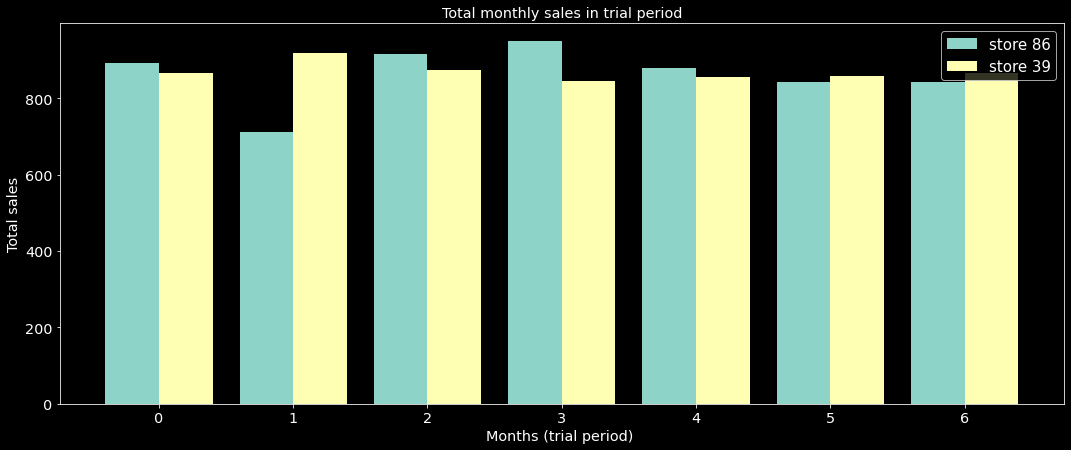

In [94]:
s_86 = pretrial_full[pretrial_full["STORE_NBR"]==86]["TOT_SALES"]

s_39 = pretrial_full[pretrial_full["STORE_NBR"]==39]["TOT_SALES"]

X_axis = np.arange(len(s_86))

plt.bar(X_axis - 0.2, s_86, 0.4, label = 'store 86')
plt.bar(X_axis + 0.2, s_39, 0.4, label = 'store 39')

plt.xlabel("Months (trial period) ")
plt.ylabel("Total sales")
plt.title("Total monthly sales in trial period")
plt.legend()
plt.show()

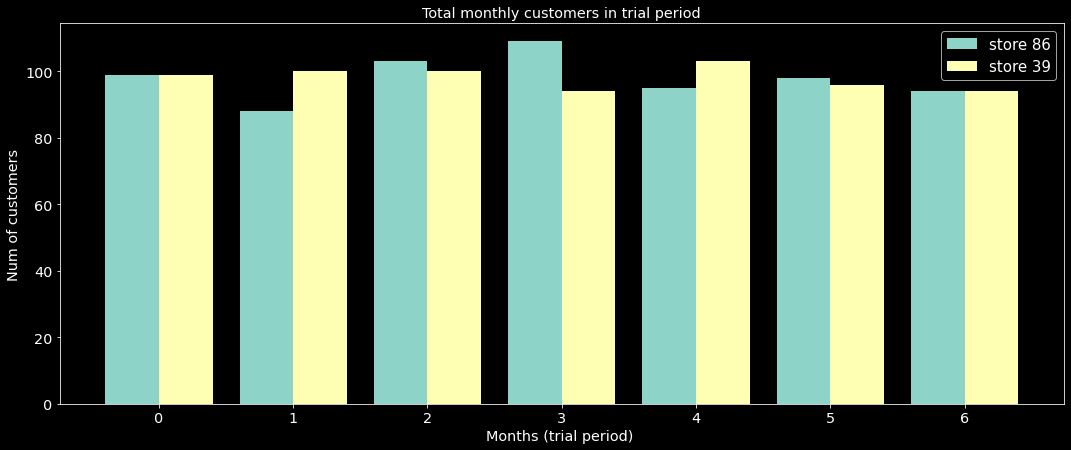

In [97]:
s_86 = pretrial_full[pretrial_full["STORE_NBR"]==86]["nCustomers"]

s_39 = pretrial_full[pretrial_full["STORE_NBR"]==39]["nCustomers"]

X_axis = np.arange(len(s_86))

plt.bar(X_axis - 0.2, s_86, 0.4, label = 'store 86')
plt.bar(X_axis + 0.2, s_39, 0.4, label = 'store 39')

plt.xlabel("Months (trial period) ")
plt.ylabel("Num of customers")
plt.title("Total monthly customers in trial period")
plt.legend()
plt.show()

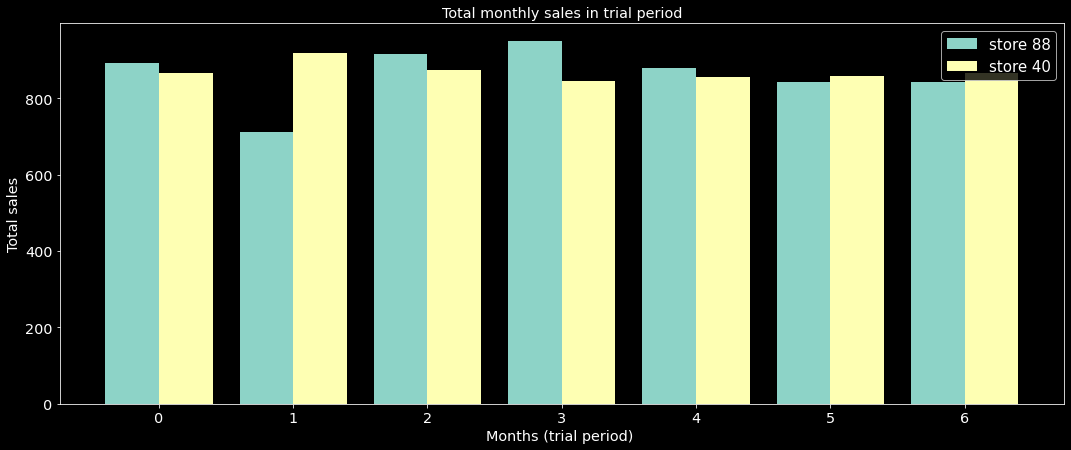

In [95]:
s_88 = pretrial_full[pretrial_full["STORE_NBR"]==88]["TOT_SALES"]

s_40 = pretrial_full[pretrial_full["STORE_NBR"]==40]["TOT_SALES"]


plt.bar(X_axis - 0.2, s_86, 0.4, label = 'store 88')
plt.bar(X_axis + 0.2, s_39, 0.4, label = 'store 40')

plt.xlabel("Months (trial period) ")
plt.ylabel("Total sales")
plt.title("Total monthly sales in trial period")
plt.legend()
plt.show()

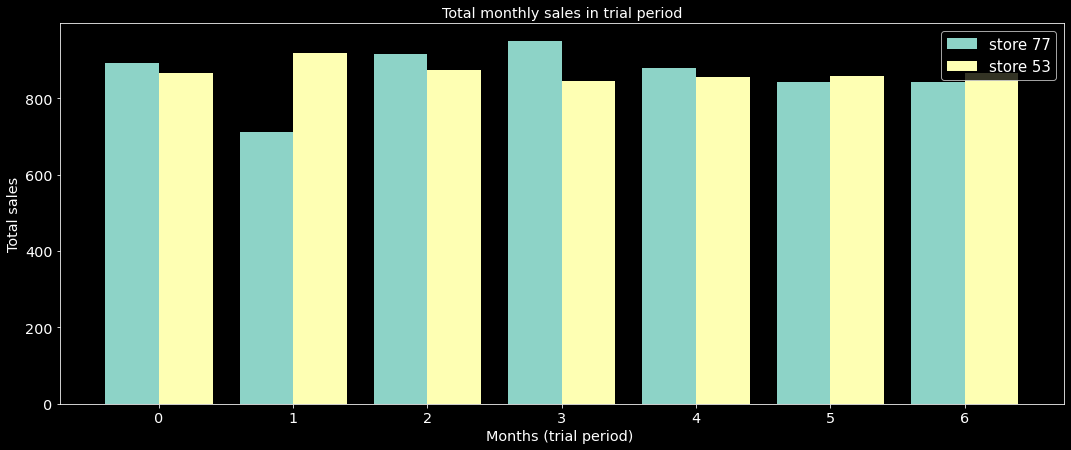

In [96]:
s_77 = pretrial_full[pretrial_full["STORE_NBR"]==77]["TOT_SALES"]

s_53 = pretrial_full[pretrial_full["STORE_NBR"]==53]["TOT_SALES"]


plt.bar(X_axis - 0.2, s_86, 0.4, label = 'store 77')
plt.bar(X_axis + 0.2, s_39, 0.4, label = 'store 53')

plt.xlabel("Months (trial period) ")
plt.ylabel("Total sales")
plt.title("Total monthly sales in trial period")
plt.legend()
plt.show()

# In conclusion
We have performed T-test to determine the statistical significance, or if there are any real/notable differences between our trial and control stores. T-test and respective P values showed insignificance for stores 77 and 88 (P> 0.05). Whereas for store 86, while the result for monthly customers was also insignificant, the difference in total sales was significant (P<0.05). In fact, the total mean sales during the trial period were lower in trial store 86 compared to control store 39.